In [1]:
import numpy as np
import xray
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (4096 ,4096 ))
resource.getrlimit(resource.RLIMIT_NOFILE)


(4096, 4096)

In [3]:
import mdsxray
reload(mdsxray)

<module 'mdsxray' from 'mdsxray.pyc'>

In [4]:
iters = range(2073840, 2384880, 480)
ddir = '/data/scratch/rpa/channel_moc/GCM/run'
store = mdsxray.MDSDataStore(ddir, iters, deltaT=900)
ds = xray.Dataset.load_store(store)
ds

mdsxray.py:200: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
mdsxray.py:200: UserWarning: Not sure what to do with rlev = X
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xray.Dataset>
Dimensions:  (X: 200, Xp1: 200, Y: 400, Yp1: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 39, time: 648)
Coordinates:
  * Xp1      (Xp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Yp1      (Yp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Y        (Y) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * X        (X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zu       (Zu) >f4 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * time     (time) int64 1866456000 1866888000 1867320000 1867752000 ...
Data variables:
    YC       (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    YG       (Yp1, Xp1) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
   

In [5]:
u = ds['UVEL']
u2mean = (u**2).mean()
% time u2mean.load()

CPU times: user 23.7 s, sys: 34.9 s, total: 58.6 s
Wall time: 2.94 s


<xray.DataArray 'UVEL' ()>
array(0.01956135767934698)

In [6]:
v = ds['VVEL']
ubar = u.mean(dim=['Xp1', 'time'])
vbar = v.mean(dim=['X', 'time'])
uprime = u - ubar
vprime = v - vbar
# cheat because u and v are on different grids
upvp = (uprime.data * vprime.data).mean(axis=[0,-1])

In [7]:
%time upvpc = upvp.compute()

CPU times: user 1min 11s, sys: 54 s, total: 2min 5s
Wall time: 29.1 s


<matplotlib.contour.QuadContourSet instance at 0x7f3fb4d6e3b0>

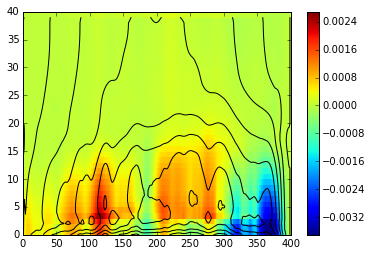

In [8]:
plt.pcolormesh(upvpc)
plt.colorbar()
plt.contour(ubar, 10, colors='k')


In [17]:
from numpy.fft import fftn
def pow_spec_2d(x, axis=[-1,-2]):
    # x and time
    f = fftn(x, axes=axis)
    return np.real(f * f.conj())

In [10]:
psurf = ds['PHIHYD'][:,0]
q = psurf.data
print repr(q)

dask.array<x_22, shape=(648, 400, 200), chunks=((1, 1, 1, ..., 1, 1), (400,), (200,)), dtype=float32>


In [14]:
%time q2dps = q.map_blocks( lambda x: pow_spec_2d(x), dtype=q.dtype).mean(axis=0).compute()
print q2dps.shape

CPU times: user 3.69 s, sys: 1.26 s, total: 4.95 s
Wall time: 1.85 s
(400, 200)


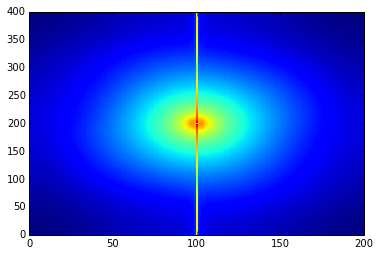

In [15]:
plt.pcolormesh(np.fft.fftshift(np.log10(q2dps)))

In [18]:
# try reduce
psurf.reduce(pow_spec_2d, dim=('X','Y'))

ValueError: dimensions ('time',) must have the same length as the number of data dimensions, ndim=3

In [5]:
# reshaping and map blocks is weird and doesn't work well

sh = q.shape
qr = q.rechunk((sh[0], 1, sh[-1]))
print repr(qr)
qrs = qr.map_blocks( lambda x: pow_spec_2d(x), dtype=q.dtype)
print repr(qrs)

dask.array<rechunk-1, shape=(648, 400, 200), chunks=((648,), (1, 1, 1, ..., 1, 1), (200,)), dtype=float32>

In [8]:
%time qrsc = qrs.compute()
# doesn't get beyond 100% cpu

KeyboardInterrupt: 

In [7]:
%time ps = (qrs.mean(axis=0)).compute()
# doesn't get beyond 100% cpu

KeyboardInterrupt: 

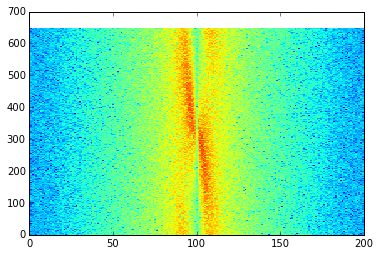

In [87]:
#plt.pcolormesh(np.fft.fftshift(np.log10(ps)))
plt.pcolormesh(np.fft.fftshift(np.log10(pow_spec_2d(ds['VVEL'][:,0,200,:]))))

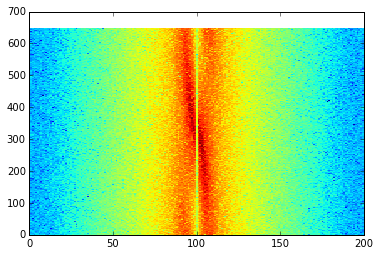

In [88]:
plt.pcolormesh(np.fft.fftshift(np.log10(pow_spec_2d(ds['VVEL'][:,20,200,:]))))